# TODO: 
- make brackets via simulation
- simulate tournement to see which brackets win the most (or place in top $p^{th}$ percentile)
- incorporate seeding/ team historical performance into model
- model average using likelihoods from old tournements

In [34]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [35]:
class Team:
    
    def __init__(self,name,seed,region,probs):
        
        self.name = name
        self.seed = seed
        self.probs = probs
        self.region = region
    
    
class Game:
    
    def __init__(self):
        
        self.teams = [0,0]
        self.pred_winner = 0
        self.winner_round_out = 6
        self.prev_games = [0,0]
        self.next_game = 0
        self.game_num = 0
        self.round_num = 0
    
    def score(self,team,gamma,seed_pow,weights):
        
        prob_win_out = sum(team.probs[self.winner_round_out:])
        
        probs = team.probs[self.round_num:self.winner_round_out]\
            + [prob_win_out]
        
        points = np.cumsum(weights)
        points = points[self.round_num:self.winner_round_out+1]
        
        EX = (team.seed**seed_pow)*np.dot(points,probs)
        
        E_X2 = (team.seed**(2*seed_pow))*np.dot(points*points,probs)
        std_dev = np.sqrt(E_X2 - EX**2)
        
        return EX + gamma*std_dev
    
    def set_winner_out(self,losing_team,round_num):
        
        if self.round_num == 0:
            return
        
        for game in self.prev_games:
            if losing_team in game.teams:
                game.winner_round_out = round_num
                game.set_winner_out(losing_team,round_num)
            
        return
    
    def predict_game(self,gamma,seed_pow,weights):
        
        if teams[0] == 0 or teams[1] == 0:
            print('Teams not Defined for Game',
                  self.game_num,
                  'Round',
                  self.round_num)
            return
        
        score_0 = self.score(self.teams[0],gamma,seed_pow,weights)
        score_1 = self.score(self.teams[1],gamma,seed_pow,weights)
        
        if score_0 > score_1:
            self.pred_winner = self.teams[0]
            self.set_winner_out(self.teams[1],self.round_num)
        else:
            self.pred_winner = self.teams[1]
            self.set_winner_out(self.teams[0],self.round_num)
        
        if self.round_num != 5:
            if self.game_num % 2 == 0:
                self.next_game.teams[0] = self.pred_winner
            else:
                self.next_game.teams[1] = self.pred_winner
        
        return
    
    
class Round:
    
    def __init__(self,round_num):
        
        self.round_num = round_num
        self.games = [Game() for i in range(int(32/(2**round_num)))]
        
    def predict_round(self,gamma,seed_pow,weights):
        
        for game in self.games:
            
            if game == 0:
                print('Games Not Defined in Round', self.round_num)
                return
            
            game.predict_game(gamma,seed_pow,weights)
    
        return
        

class Bracket:
    
    def __init__(self,teams,weights):
        
        self.rounds = [Round(i) for i in range(6)]
            
        for rnd in self.rounds:
            i = 0
            
            for game in rnd.games:
                
                game.game_num = i
                game.round_num = rnd.round_num
                
                if rnd.round_num == 0:
                    game.teams = teams[2*i:(2*i+2)]
                
                if rnd.round_num  != 5:
                    game.next_game = \
                    self.rounds[rnd.round_num+1].games[int(np.floor(i/2))]
                    
                if rnd.round_num != 0:
                    game.prev_games = \
                    self.rounds[rnd.round_num-1].games[2*i:(2*i+2)]
                
                i = i+1
                
    def predict_bracket(self,gamma,seed_pow,weights):
        
        for rnd in self.rounds:
            rnd.predict_round(gamma,seed_pow,weights)
            
        return
    
    def print_teams(self):
        for rnd in self.rounds:
            print("")
            print("Round", rnd.round_num,"winners:")
            print("")
            for game in rnd.games:
                print(game.pred_winner.name)

In [36]:
def process_probs(probs):
    
    '''
    change probs from the probabilty of making it to a round
    to the probability of getting out at that round
    '''
    
    new_probs = [1-probs[0]]
    for i in range(len(probs)-1):
        prob_out = probs[i]*(1-(probs[i+1]/probs[i]))
        new_probs.append(prob_out)
    new_probs.append(probs[-1])
    
    return new_probs

def seed_reg_2_ind(seed,region):
    
    seed_order = [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]
    region_order = ['South','West','East','Midwest']
    
    return 16*region_order.index(region) + seed_order.index(seed)

def make_teams(
    file,date,gender,
    date_ind,gender_ind,alive_ind,name_ind,seed_ind,region_ind,prob_inds):
    
    teams = [0]*64
    f = open(file)
    reader = csv.reader(f)
    for row in reader:
        if row[gender_ind] == gender and \
            row[date_ind] == date and \
            int(row[alive_ind]) == 1:
                
            probs = [float(row[i]) for i in prob_inds]
            probs = process_probs(probs)
            
            name = row[name_ind]
            
            if row[seed_ind] == '11a' or row[seed_ind] == '11b':
                seed = 11
            elif row[seed_ind] == '16a' or row[seed_ind] == '16b':
                seed = 16
            else:
                seed = int(row[seed_ind])
                
            region = row[region_ind]
            
            ind = seed_reg_2_ind(seed,region)
            teams[ind] = Team(name,seed,region,probs)
            
    return teams

In [79]:
seed_pow = 1
weights = [0,1,2,4,6,8,10]
var_pen = 0
pred_iterations = 10

date = '2018-03-14'
gender = 'mens'
file = 'fivethirtyeight_probs_2018.csv'

gender_ind = 0
date_ind = 1
alive_ind = 10
name_ind = 12
seed_ind = 15
region_ind = 14
prob_inds = [4,5,6,7,8,9]

teams = make_teams(
    file,date,gender,
    date_ind,gender_ind,alive_ind,name_ind,seed_ind,region_ind,prob_inds)

In [80]:
Brac = Bracket(teams,weights)
for _ in range(pred_iterations):
    Brac.predict_bracket(var_pen,seed_pow,weights)
Brac.print_teams()


Round 0 winners:

Virginia
Creighton
Kentucky
Arizona
Loyola (IL)
Tennessee
Texas
Cincinnati
Xavier
Florida State
Ohio State
Gonzaga
Houston
Michigan
Texas A&M
North Carolina
Villanova
Virginia Tech
West Virginia
Wichita State
Florida
Texas Tech
Butler
Purdue
Kansas
Seton Hall
New Mexico State
Auburn
Syracuse
Michigan State
Rhode Island
Duke

Round 1 winners:

Creighton
Kentucky
Loyola (IL)
Cincinnati
Florida State
Gonzaga
Houston
Texas A&M
Virginia Tech
West Virginia
Florida
Butler
Seton Hall
New Mexico State
Michigan State
Rhode Island

Round 2 winners:

Kentucky
Cincinnati
Gonzaga
Houston
West Virginia
Florida
New Mexico State
Michigan State

Round 3 winners:

Cincinnati
Gonzaga
West Virginia
Michigan State

Round 4 winners:

Gonzaga
Michigan State

Round 5 winners:

Gonzaga


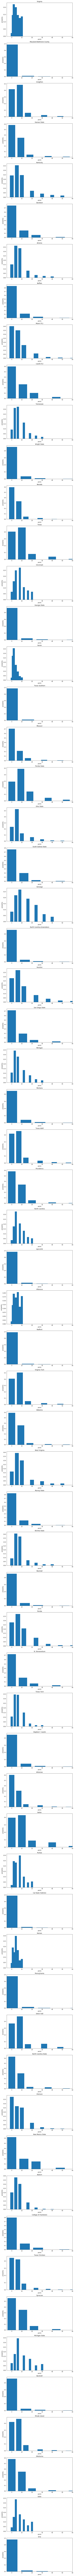

In [81]:
plt.subplots(figsize=(10, 400))
for n,team in enumerate(teams):
    plt.subplot(64,1,n+1)
    points = np.multiply(team.seed,weights)
    plt.bar(points,team.probs,max(2,0.75*team.seed))
    plt.xlim([-5,60])
    plt.xlabel("points")
    plt.ylabel("probability")
    plt.title(team.name)

plt.show()